In [1]:
import numpy as np
import os
import pandas as pd
import torch
import albumentations as A
import albumentations.pytorch
import cv2
import sys
import random
import csv
import matplotlib.pyplot as plt
sys.path.append('../')

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import Sampler
import torch.optim as optim

import config
from model import YOLOv3
from dataset import LbpDataset, train_transforms, val_transforms
# from dataset import LbpDataset
from train import  train_fn
from scheduler import CosineAnnealingWarmUpRestarts

from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples,
    non_max_suppression,
    plot_image
)
from loss import YoloLoss
from visualize import visualize

In [2]:
model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)
loss_fn = YoloLoss().to(config.DEVICE)
scaler = torch.cuda.amp.GradScaler()

In [3]:
df = pd.read_csv('../data/df.csv')
df['label_id'] = df.label.apply( lambda x : 0.)
df_data = df.groupby('path')
def get_data(img_id):
    if img_id not in df_data.groups:
        return dict(image_id=img_id, boxes=list())
    
    data  = df_data.get_group(img_id)
#     boxes = data['bbox'].values
    boxes = data[['xmin', 'ymin', 'w', 'h', 'label_id']].values
#     labels = data['label'].values
    return dict(image_id = img_id, boxes = boxes)
#     return dict(image_id = img_id, boxes = boxes, labels=labels)

train_list = [get_data(img_id) for img_id in df.path.unique()]
# df.head()
train_list[0]

{'image_id': 'patch_images/2021.01.08/LBC141-20210105(1)/LBC141-20210105(1)_1001.png',
 'boxes': array([[1558., 1603.,   96.,   73.,    0.],
        [1452., 1263.,   82.,   94.,    0.]])}

In [4]:
path = '/home/Dataset/scl/patch_images/2021.01.06/LBC24-20210102(1)/'
file_list = ['patch_images/2021.01.06/LBC24-20210102(1)/' + d for d in os.listdir(path)]
file_list[:2]

['patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1160.png',
 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1817.png']

In [5]:
test_list = [get_data(img_id) for img_id in file_list]
test_list[:2]

[{'image_id': 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1160.png',
  'boxes': []},
 {'image_id': 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1817.png',
  'boxes': []}]

In [6]:
IMAGE_SIZE = config.IMAGE_SIZE
train_dataset = LbpDataset(
    train_list,
    transform=train_transforms,
    S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
    anchors=config.ANCHORS,
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)

test_dataset = LbpDataset(
    test_list,
    transform=val_transforms,
    S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
    anchors=config.ANCHORS,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=8,
    num_workers=config.NUM_WORKERS,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)

In [7]:
# next(iter(test_dataset))

In [8]:
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
scaled_anchors.shape

torch.Size([3, 3, 2])

In [9]:
# saved_dir = '../trained_model/'
# state = torch.load(saved_dir + 'epoch_' + str(90) +'_model.pt')
# epoch = state['epoch']
# model.load_state_dict(state['state_dict'], strict=False)
# optimizer.load_state_dict(state['optimizer'])
# # scheduler.load_state_dict(state['scheduler'])

  0%|          | 0/25 [00:00<?, ?it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 5.716961%
Obj accuracy is: 69.922150%


  0%|          | 0/25 [00:00<?, ?it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 24.720755%
Obj accuracy is: 44.349678%


  0%|          | 0/25 [00:00<?, ?it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 48.863056%
Obj accuracy is: 40.256042%


  0%|          | 0/25 [00:00<?, ?it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 74.333817%
Obj accuracy is: 35.527248%


  0%|          | 0/25 [00:00<?, ?it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 90.100014%
Obj accuracy is: 31.351734%


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 96.528557%
Obj accuracy is: 26.453899%


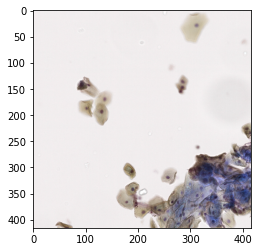

<Figure size 360x360 with 0 Axes>

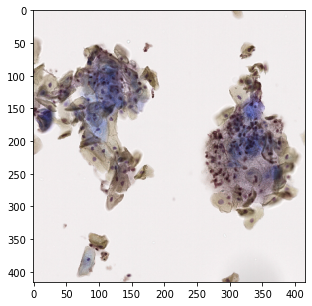

<Figure size 360x360 with 0 Axes>

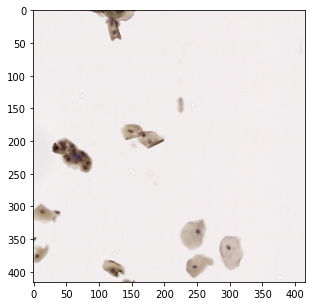

<Figure size 360x360 with 0 Axes>

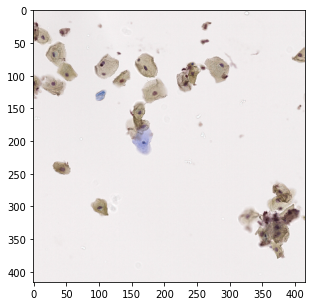

<Figure size 360x360 with 0 Axes>

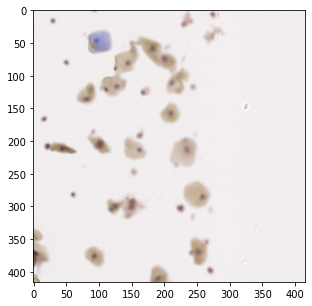

<Figure size 360x360 with 0 Axes>

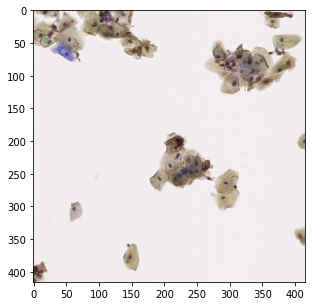

<Figure size 360x360 with 0 Axes>

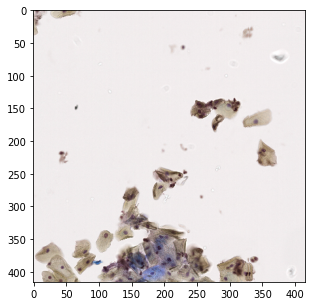

<Figure size 360x360 with 0 Axes>

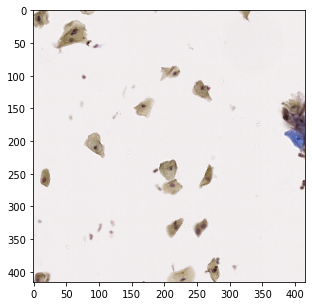

<Figure size 360x360 with 0 Axes>

100%|██████████| 25/25 [00:08<00:00,  2.97it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 98.310005%
Obj accuracy is: 26.912182%


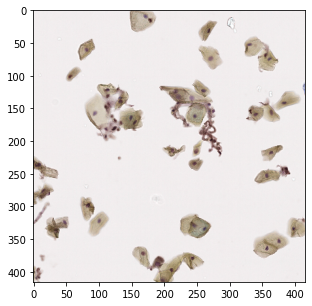

<Figure size 360x360 with 0 Axes>

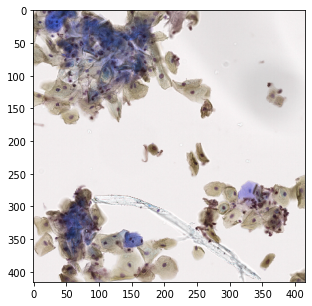

<Figure size 360x360 with 0 Axes>

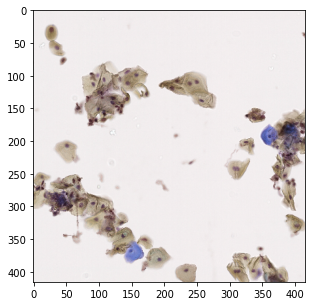

<Figure size 360x360 with 0 Axes>

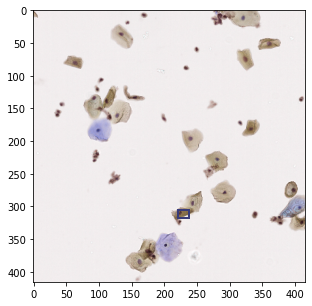

<Figure size 360x360 with 0 Axes>

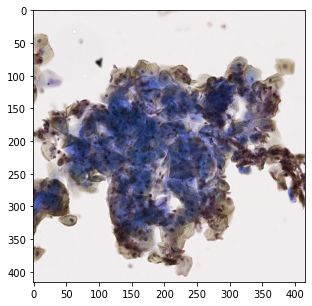

<Figure size 360x360 with 0 Axes>

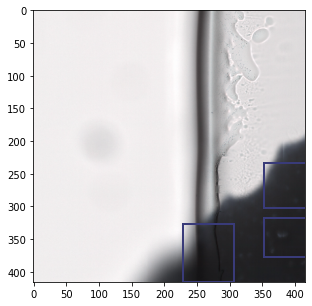

<Figure size 360x360 with 0 Axes>

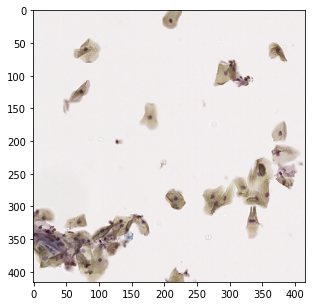

<Figure size 360x360 with 0 Axes>

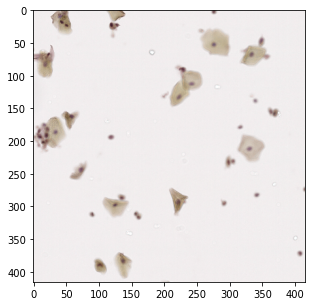

<Figure size 360x360 with 0 Axes>

100%|██████████| 25/25 [00:08<00:00,  2.98it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 98.915558%
Obj accuracy is: 26.445698%


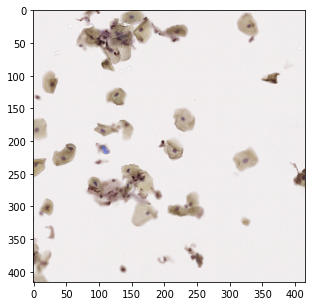

<Figure size 360x360 with 0 Axes>

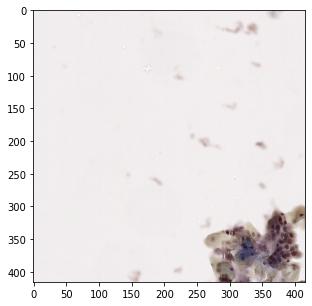

<Figure size 360x360 with 0 Axes>

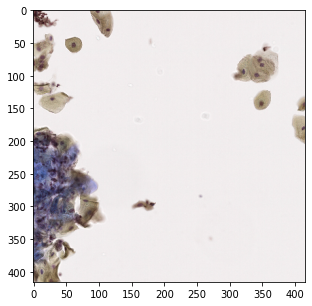

<Figure size 360x360 with 0 Axes>

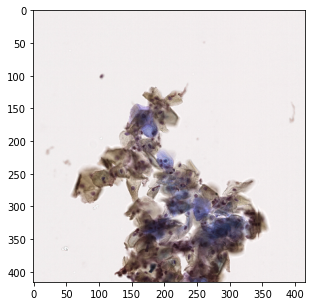

<Figure size 360x360 with 0 Axes>

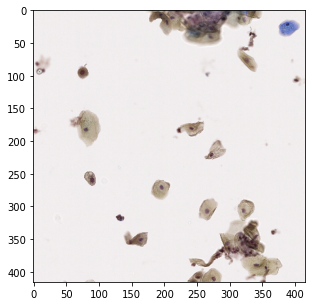

<Figure size 360x360 with 0 Axes>

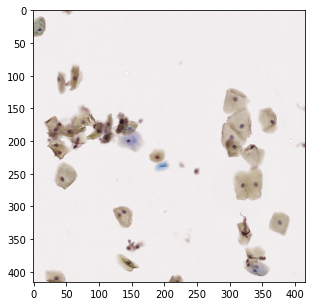

<Figure size 360x360 with 0 Axes>

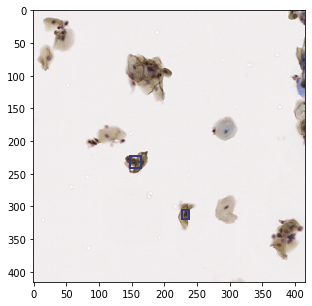

<Figure size 360x360 with 0 Axes>

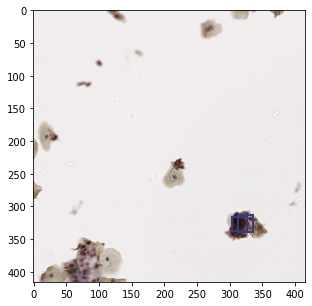

<Figure size 360x360 with 0 Axes>

100%|██████████| 25/25 [00:08<00:00,  2.95it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.022034%
Obj accuracy is: 26.794598%


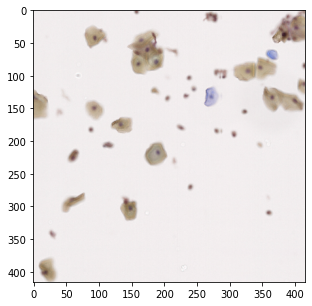

<Figure size 360x360 with 0 Axes>

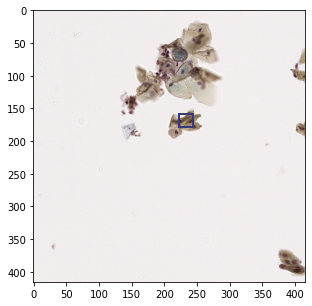

<Figure size 360x360 with 0 Axes>

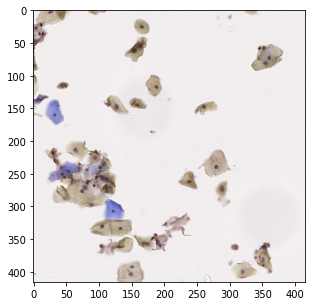

<Figure size 360x360 with 0 Axes>

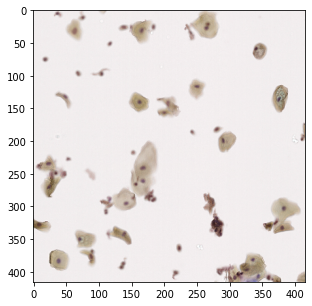

<Figure size 360x360 with 0 Axes>

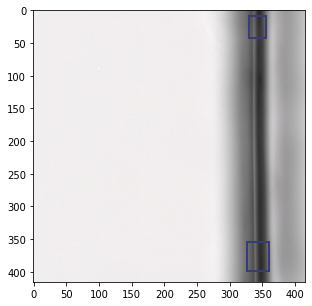

<Figure size 360x360 with 0 Axes>

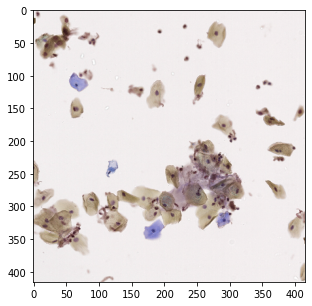

<Figure size 360x360 with 0 Axes>

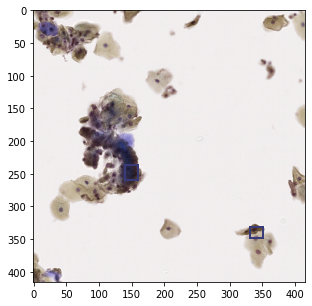

<Figure size 360x360 with 0 Axes>

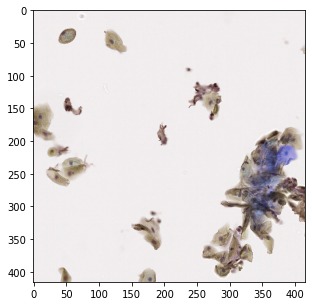

<Figure size 360x360 with 0 Axes>

100%|██████████| 25/25 [00:09<00:00,  2.53it/s, loss=3.13]


In [10]:
for epoch in range(config.NUM_EPOCHS):
    #plot_couple_examples(model, test_loader, 0.6, 0.5, scaled_anchors)
    model.train()
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)

    if epoch > 0 and epoch % 10 == 0:
        model.eval()
        check_class_accuracy(model, train_loader, threshold=config.CONF_THRESHOLD)
        if epoch > 55:
            plot_couple_examples(model, test_loader, 0.5, 0.4, scaled_anchors)
#         pred_boxes, true_boxes = get_evaluation_bboxes(
#             test_loader,
#             model,
#             iou_threshold=config.NMS_IOU_THRESH,
#             anchors=config.ANCHORS,
#             threshold=config.CONF_THRESHOLD,
#         )
#         mapval = mean_average_precision(
#             pred_boxes,
#             true_boxes,
#             iou_threshold=config.MAP_IOU_THRESH,
#             box_format="midpoint",
#             num_classes=config.NUM_CLASSES,
#         )
#         print(f"MAP: {mapval.item()}")


In [11]:
# def plot_couple_examples(model, loader, thresh, iou_thresh, anchors):
# # def plot_couple_examples(model, x, y, thresh, iou_thresh, anchors):
#     model.eval()
#     x, y = next(iter(loader))
#     batch_size, width, height, channel = x.shape
# #     x = x.view(batch_size, channel, width, height).float().to(config.DEVICE)
#     x = x.permute(0,3,1,2).float().to(config.DEVICE)
#     with torch.no_grad():
#         out = model(x)
#         bboxes = [[] for _ in range(x.shape[0])]
#         for i in range(3):
#             batch_size, A, S, _, _ = out[i].shape
#             anchor = anchors[i]
#             boxes_scale_i = cells_to_bboxes(
#                 out[i], anchor, S=S, is_preds=True
#             )
#             for idx, (box) in enumerate(boxes_scale_i):
#                 bboxes[idx] += box

#         model.train()

#     for i in range(batch_size):
#         nms_boxes = non_max_suppression(
#             bboxes[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
#         )
#         plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)

In [12]:
# plot_couple_examples(model, test_loader, 0.5, 0.5, scaled_anchors)

torch.Size([8, 3, 416, 416])
10647
torch.Size([416, 416, 3])


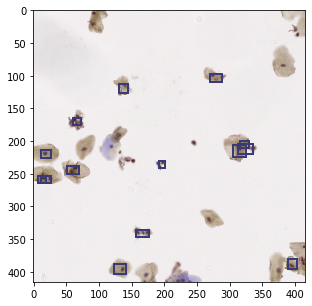

<Figure size 360x360 with 0 Axes>

10647
torch.Size([416, 416, 3])


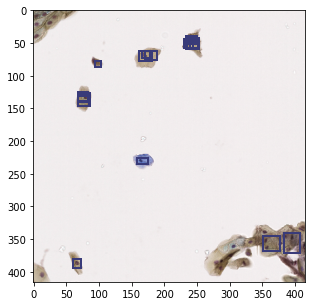

<Figure size 360x360 with 0 Axes>

10647
torch.Size([416, 416, 3])


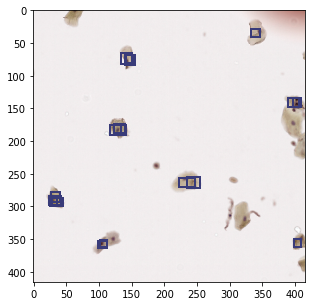

<Figure size 360x360 with 0 Axes>

10647
torch.Size([416, 416, 3])


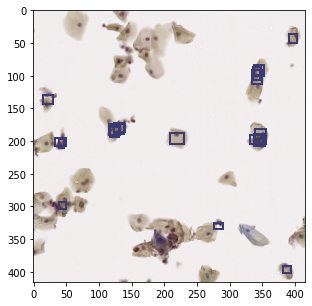

<Figure size 360x360 with 0 Axes>

10647
torch.Size([416, 416, 3])


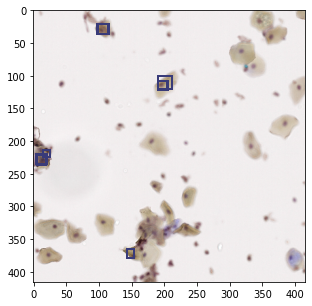

<Figure size 360x360 with 0 Axes>

10647
torch.Size([416, 416, 3])


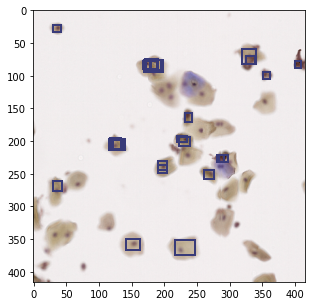

<Figure size 360x360 with 0 Axes>

10647
torch.Size([416, 416, 3])


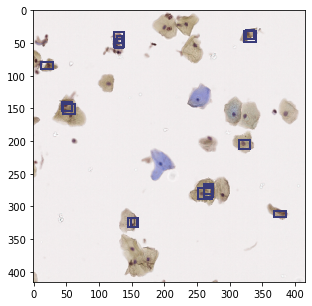

<Figure size 360x360 with 0 Axes>

10647
torch.Size([416, 416, 3])


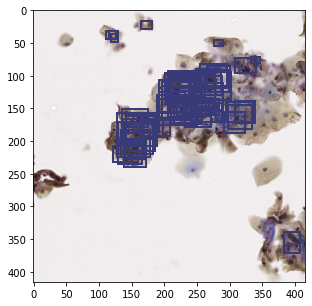

<Figure size 360x360 with 0 Axes>

In [18]:
x, y = next(iter(test_loader))
# batch_size, width, height, channel = x.shape
# x = x.permute(0,3,1,2).float().to(config.DEVICE)
x = x.to(config.DEVICE)
print(x.shape)

with torch.no_grad():
    out = model(x)
    bboxes = [[] for _ in range(x.shape[0])]
    for i in range(3):
        batch_size, A, S, _, _ = out[i].shape
        anchor = scaled_anchors[i]
        boxes_scale_i = cells_to_bboxes(
            out[i], anchor, S=S, is_preds=True
        )
        for idx, (box) in enumerate(boxes_scale_i):
            bboxes[idx] += box
        
for i in range(batch_size):
    print(len(bboxes[i]))   
    nms_boxes = non_max_suppression(
        bboxes[i], iou_threshold=0.8, threshold=0.30, box_format="midpoint",
    )
    print(x[i].permute(1,2,0).shape)
    plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)       

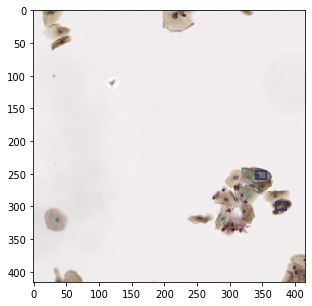

<Figure size 360x360 with 0 Axes>

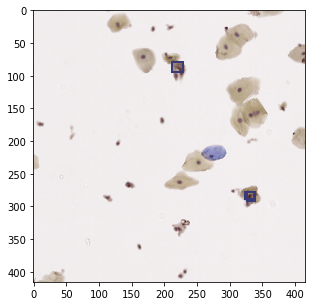

<Figure size 360x360 with 0 Axes>

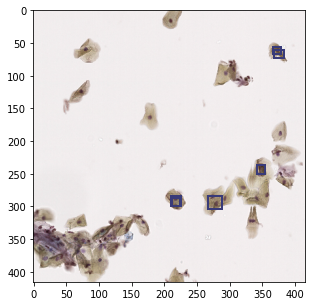

<Figure size 360x360 with 0 Axes>

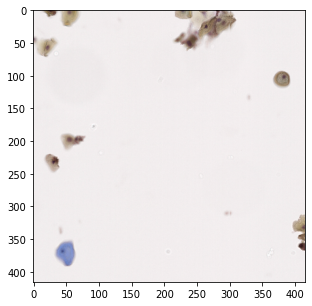

<Figure size 360x360 with 0 Axes>

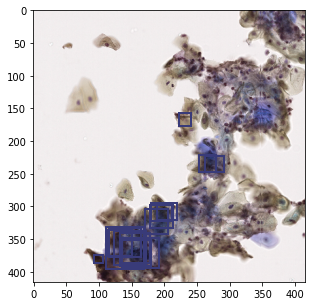

<Figure size 360x360 with 0 Axes>

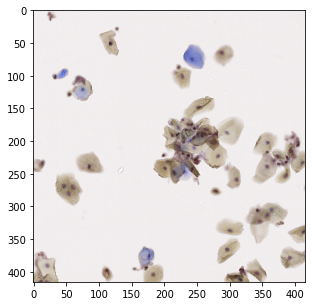

<Figure size 360x360 with 0 Axes>

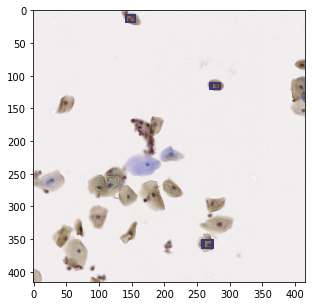

<Figure size 360x360 with 0 Axes>

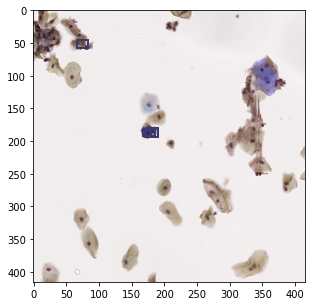

<Figure size 360x360 with 0 Axes>

In [21]:
plot_couple_examples(model, test_loader, 0.4, 0.8, scaled_anchors)